In [22]:
# With native Python3 environment -- It takes around 12 minutes to evaluate one day
import os
import sys
import json
import numpy as np
import xarray as xr
import sympy as sp
import matplotlib.pyplot as plt

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/cloud_cover_parameterization/')
import my_classes
from my_classes import load_data

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression/')
from functions import add_derivatives
from functions import append_dict_to_json

**Load data**

In [8]:
all_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
              'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']
path_data = os.path.join('/home/b/b309170/', 'my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND')
input_data = np.load(path_data + '/cloud_cover_input_dyamond.npy')
output_data = np.load(path_data + '/cloud_area_output_dyamond.npy')

(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

loc_all = {}
for i in range(len(all_features)):
    loc_all[all_features[i]] = i

**We evaluate on cloud regimes**

Refer to symbolic_regression/finding_symmetries/seq_feature_selector_dyamond_nns.ipynb.

In [9]:
a = 1

cod_subs = a*input_data[:, loc_all['cli']] + input_data[:, loc_all['clw']]
cod_subs_med = np.median(cod_subs[cod_subs != 0])

pa_med = np.median(input_data[cod_subs != 0, loc_all['pa']])

# For the training data
input_data_reg_1 = input_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
input_data_reg_2 = input_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]
input_data_reg_3 = input_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
input_data_reg_4 = input_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]

output_data_reg_1 = output_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
output_data_reg_2 = output_data[(0 < cod_subs) & (cod_subs < cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]
output_data_reg_3 = output_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] < pa_med)]
output_data_reg_4 = output_data[(cod_subs > cod_subs_med) & (input_data[:, loc_all['pa']] > pa_med)]

# Do the regimes have a similar size?
for i in range(1, 5):
    print(locals()['input_data_reg_%d'%i].shape)
    print(locals()['output_data_reg_%d'%i].shape)

(58421418, 24)
(58421418,)
(35374362, 24)
(35374362,)
(35374356, 24)
(35374356,)
(58421401, 24)
(58421401,)


**Keeping only the relevant features**

In [10]:
features = ['rh', 'ta', 'clw', 'cli', 'rh_z']
inds = [loc_all[feat] for feat in features]
for reg in range(1, 5):
    locals()['input_data_reg_%d'%reg] = locals()['input_data_reg_%d'%reg][:, inds]
no_features = input_data_reg_1.shape[1]

In [11]:
# Update loc
loc = {}
for i in range(len(features)):
    loc[features[i]] = i

**Normalize the features**

In [12]:
features = ['rh', 'ta', 'clw', 'cli', 'rh_z']

# Scale the data
mean_all = [4.12205844e-03,2.25493498e-05,3.38180032e-06,2.57065512e+02,6.00030443e+04,5.64080139e+03,2.35046400e-01,1.32776682e+01,6.02512234e-01,9.86270417e+04,-1.27545273e-06,-4.02484958e-10,1.65204582e-08,-4.34660202e-11,4.29441131e-10,-1.82817316e-12,-4.68742483e-03,-7.54899040e-07,-7.51544542e+00,-1.06989723e-04,1.65615172e-03,-9.27604679e-06,-4.76200071e-05,-1.32246548e-07]
std_all = [5.07648249e-03,5.69702638e-05,1.01308124e-05,3.00533874e+01,3.12514292e+04,5.66963918e+03,4.11184302e-01,1.11389888e+01,3.32494615e-01,6.24039256e+03,2.03179260e-06,1.17041141e-08,1.33311867e-07,1.42840744e-09,6.73384546e-09,5.07424672e-11,5.82875686e-03,6.34826092e-05,3.53136052e+00,1.13215264e-02,6.62892130e-03,6.08144307e-05,2.58065098e-04,2.49552692e-06]

mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

# Work with scaled regimes
for reg in range(1, 5):
    locals()['input_scaled_%d'%reg] = (locals()['input_data_reg_%d'%reg] - mean)/std

In [13]:
def func(X):
    # X = ['rh', 't', 'clwc', 'ciwc', 'rh_z']
    x0 = X[:, 0] 
    x1 = X[:, 1] 
    x2 = X[:, 2] 
    x3 = X[:, 3]
    x4 = X[:, 4]
    return 19.784*x0*(1.13638*x0 + x1**2) + 38.6562*x0 - 43.535*x1 + x4**2*(0.352999*x4 + 4.04889) + 44.2173 - 2.03129/(x2 + 0.669716*x3 + 0.640902)

In [14]:
# Regime-based evaluation

results = {}
all_preds = []

for reg in range(1, 5):
    X = locals()['input_scaled_%d'%reg]
    y = locals()['output_data_reg_%d'%reg]
    all_preds.append(np.minimum(np.maximum(func(X), 0), 100))
    reg_mse = np.mean((all_preds[reg - 1] - y)**2, dtype=np.float64)
    r2 = 1-reg_mse/np.var(y)
    
    results['Regime %d MSE'%reg] = reg_mse
    results['Regime %d R2'%reg] = r2

**Save results**

The high variance of the output data pushes the R2-score in the cirrus and cumulus regimes. <br>
Note that in the json-file the R2-score and the MSE paint two very different pictures!

In [15]:
# Dump results
with open('/home/b/b309170/workspace_icon-ml/symbolic_regression/evaluate_schemes/on_isccp_regimes/results/evaluate_EQ4.json', 'w') as file:
    json.dump(results, file)

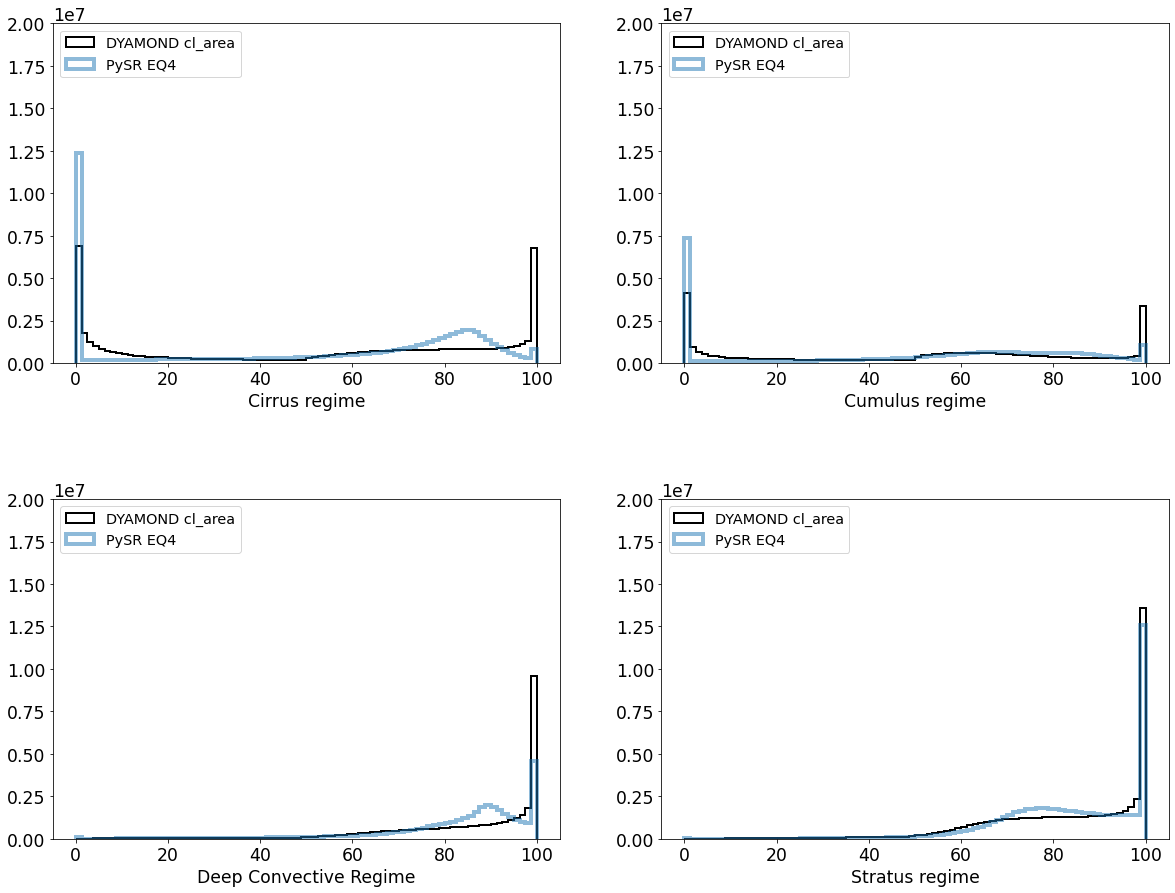

In [21]:
import matplotlib
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.labelsize'] = 'xx-large' # For an axes xlabel and ylabel
matplotlib.rcParams['xtick.labelsize'] = 'xx-large'
matplotlib.rcParams['ytick.labelsize'] = 'xx-large'

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.4)
# plt.suptitle("Distributions on all validation data vs on the subset", fontsize=18, y=.91)

feats = ['Cirrus regime', 'Cumulus regime', 'Deep Convective Regime', 'Stratus regime']

hist_data = {}
hist_preds = {}

axes = (0,1,2,3)
for reg, par in enumerate(feats):
    # Add new subplot iteratively
    ax = plt.subplot(2, 2, reg + 1)
    
    axis = axes[:reg] + axes[(reg+1):]
    hist_data['Data_reg_%d'%reg] = ax.hist(locals()['output_data_reg_%d'%(reg+1)], bins=80, histtype='step', color='k', linewidth=2)
    hist_preds['Preds_reg_%d'%reg] = ax.hist(all_preds[reg], bins=80, alpha=.5, histtype='step', linewidth=4)
    
    plt.legend(['DYAMOND cl_area', 'PySR EQ4'], loc='upper left')
    plt.xlabel(par)
    plt.ylim((0, 2*10**7))
    
plt.savefig('/home/b/b309170/workspace_icon-ml/symbolic_regression/evaluate_schemes/on_isccp_regimes/results/evaluate_EQ4.pdf')

In [23]:
hist_data_json = {}
for key in hist_data.keys():
    hist_data_json[key + '_x'] = list(hist_data[key][0])
    hist_data_json[key + '_y'] = list(np.array(hist_data[key][1], dtype='float64'))
    
hist_preds_json = {}
for key in hist_preds.keys():
    hist_preds_json[key + '_x'] = list(hist_preds[key][0])
    hist_preds_json[key + '_y'] = list(np.array(hist_preds[key][1], dtype='float64'))

In [25]:
append_dict_to_json(hist_data_json, '/home/b/b309170/workspace_icon-ml/symbolic_regression/evaluate_schemes/on_isccp_regimes/results/evaluate_EQ4.json')
append_dict_to_json(hist_preds_json, '/home/b/b309170/workspace_icon-ml/symbolic_regression/evaluate_schemes/on_isccp_regimes/results/evaluate_EQ4.json')